# Sistema de Recomendação por Similaridade Visual

## 1. Instalar

In [1]:
# ===============================================
# SISTEMA DE RECOMENDAÇÃO POR SIMILARIDADE VISUAL
# ===============================================

# ---------------- INSTALAÇÕES ----------------
!pip install -q icrawler

import os
import io
import zipfile
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from icrawler.builtin import BingImageCrawler



In [12]:
!pip install faiss-cpu #nao dá pra instalar faiss-gpu diretamente via pip porque o pacote oficial só funciona em alguns ambientes Linux com CUDA específicos.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 74.7 MB/s eta 0:00:00


## 2. Configurar

In [2]:
# Diretórios
root = Path("/content/image_reco")
data_dir = root / "data"
query_dir = root / "query"
os.makedirs(data_dir, exist_ok=True)
os.makedirs(query_dir, exist_ok=True)

# Classes: chave curta para match no ZIP, valor longo para crawler
classes = {
    "cadeira": "cadeira gamer cadeira de escritório ergonômica",
    "ursinho": "ursinho de pelúcia brinquedo infantil",
    "bolsa": "bolsa feminina acessório moda",
    "chapeu": "chapéu acessório de roupa"
}

num_images_per_class = 40
img_size = (224,224)
top_k = 4


## 3. Upload do ZIP com as Imagens

In [6]:
# ----------------- UPLOAD DO ZIP -----------------
print("Faça upload do ZIP com 4 imagens (nome do arquivo deve conter a palavra da classe correspondente).")
from google.colab import files
uploaded = files.upload()

for fname in uploaded.keys():
    if fname.endswith(".zip"):
        with zipfile.ZipFile(io.BytesIO(uploaded[fname]), "r") as z:
            z.extractall(query_dir)
        print(f"ZIP '{fname}' extraído em {query_dir}")



Faça upload do ZIP com 4 imagens (nome do arquivo deve conter a palavra da classe correspondente).


Saving meus_itens.zip to meus_itens (1).zip
ZIP 'meus_itens (1).zip' extraído em /content/image_reco/query


## 4. Baixar imagens da Web

In [7]:
# ---------- 4) Baixar imagens da web ----------
for short_cls, long_desc in classes.items():
    target_dir = os.path.join(data_dir, short_cls)
    os.makedirs(target_dir, exist_ok=True)

    print(f"Baixando imagens para '{long_desc}' ...")
    crawler = BingImageCrawler(storage={"root_dir": target_dir})
    crawler.crawl(keyword=long_desc, max_num=num_images_per_class)

print("✅ Download de referência finalizado!")




Baixando imagens para 'cadeira gamer cadeira de escritório ergonômica' ...


ERROR:downloader:Exception caught when downloading file https://cadeiras.consertosdecadeiras.com.br/imagens/cadeira-gamer-ergonomica-valor.jpg, error: HTTPSConnectionPool(host='cadeiras.consertosdecadeiras.com.br', port=443): Max retries exceeded with url: /imagens/cadeira-gamer-ergonomica-valor.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://cadeiras.consertosdecadeiras.com.br/imagens/cadeira-gamer-ergonomica-valor.jpg, error: HTTPSConnectionPool(host='cadeiras.consertosdecadeiras.com.br', port=443): Max retries exceeded with url: /imagens/cadeira-gamer-ergonomica-valor.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1010)'))), remaining retry times: 1
ERROR:downloader:Exception caught when downl

Baixando imagens para 'ursinho de pelúcia brinquedo infantil' ...


ERROR:downloader:Exception caught when downloading file https://images-americanas.b2w.io/produtos/7099678048/imagens/brinquedo-de-pelucia-infantil-disney-tigrao-60-cm-disney-ursinho-pooh/7099678072_1_large.jpg, error: HTTPSConnectionPool(host='images-americanas.b2w.io', port=443): Read timed out. (read timeout=5), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://images-americanas.b2w.io/produtos/7099678048/imagens/brinquedo-de-pelucia-infantil-disney-tigrao-60-cm-disney-ursinho-pooh/7099678072_1_large.jpg, error: HTTPSConnectionPool(host='images-americanas.b2w.io', port=443): Read timed out. (read timeout=5), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://images-americanas.b2w.io/produtos/7099678048/imagens/brinquedo-de-pelucia-infantil-disney-tigrao-60-cm-disney-ursinho-pooh/7099678072_1_large.jpg, error: HTTPSConnectionPool(host='images-americanas.b2w.io', port=443): Read timed out. (read timeout=5), re

Baixando imagens para 'bolsa feminina acessório moda' ...


ERROR:downloader:Response status code 403, file https://static.riachuelo.com.br/RCHLO/14655004001/portrait/e3f541d8dbb0d5b6c8140020d91fc039de278f29.jpg
ERROR:downloader:Exception caught when downloading file https://images-americanas.b2w.io/produtos/5163631544/imagens/kit-4-bolsas-feminina-bags-de-otima-qualidade-bolsa-sacola-bolsa-transversal-carteira-de-mao/5163631544_1_xlarge.jpg, error: HTTPSConnectionPool(host='images-americanas.b2w.io', port=443): Read timed out. (read timeout=5), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://images-americanas.b2w.io/produtos/5163631544/imagens/kit-4-bolsas-feminina-bags-de-otima-qualidade-bolsa-sacola-bolsa-transversal-carteira-de-mao/5163631544_1_xlarge.jpg, error: HTTPSConnectionPool(host='images-americanas.b2w.io', port=443): Read timed out. (read timeout=5), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://images-americanas.b2w.io/produtos/5163631544/imagens/k

Baixando imagens para 'chapéu acessório de roupa' ...
✅ Download de referência finalizado!


## 5. Mapear imagens do ZIP

In [8]:
# ---------- 5) Mapear imagens do ZIP ----------
query_map = {}
for fname in os.listdir(query_dir):
    for short_cls in classes.keys():
        if short_cls in fname.lower():
            query_map[short_cls] = os.path.join(query_dir, fname)

missing = [cls for cls in classes.keys() if cls not in query_map]
if missing:
    raise ValueError(f"⚠️ Faltam imagens para as classes: {missing}")

print("✅ Todas as classes já têm imagem!")
for cls, path in query_map.items():
    print(f"Classe '{cls}' -> {path}")



✅ Todas as classes já têm imagem!
Classe 'ursinho' -> /content/image_reco/query/ursinho.jpg
Classe 'cadeira' -> /content/image_reco/query/cadeira-gamer-alpha-gamer-zeta-black-agzeta-bk_1579800949_gg.webp
Classe 'bolsa' -> /content/image_reco/query/bolsa.webp
Classe 'chapeu' -> /content/image_reco/query/chapeu.webp


## 6. Modelo para extração de embeddings

In [9]:
# ---------- 6) Modelo para extração de embeddings ----------
base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base.output)
model = Model(inputs=base.input, outputs=x)

def extrair_features(img_path):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)[0]
    feat = feat / np.linalg.norm(feat)  # normalizar para cosine similarity
    return feat



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 7. Construir índice das imagens baixadas

In [13]:
# ---------- 7) Construir índice das imagens baixadas ----------
import faiss

all_img_paths = []
embeddings = []

for short_cls in classes.keys():
    cls_dir = os.path.join(data_dir, short_cls)
    paths = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    for p in tqdm(paths, desc=f"Extraindo embeddings {short_cls}"):
        try:
            feat = extrair_features(p)
            embeddings.append(feat)
            all_img_paths.append(p)
        except Exception as e:
            print(f"Erro {p}: {e}")

embeddings = np.vstack(embeddings).astype('float32')
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
print(f"✅ Índice construído com {len(all_img_paths)} imagens.")



Extraindo embeddings chapeu: 100%|██████████| 40/40 [00:04<00:00,  8.74it/s]

✅ Índice construído com 136 imagens.


## 8. Consultar similaridade


🔎 Buscando similares para 'ursinho'...



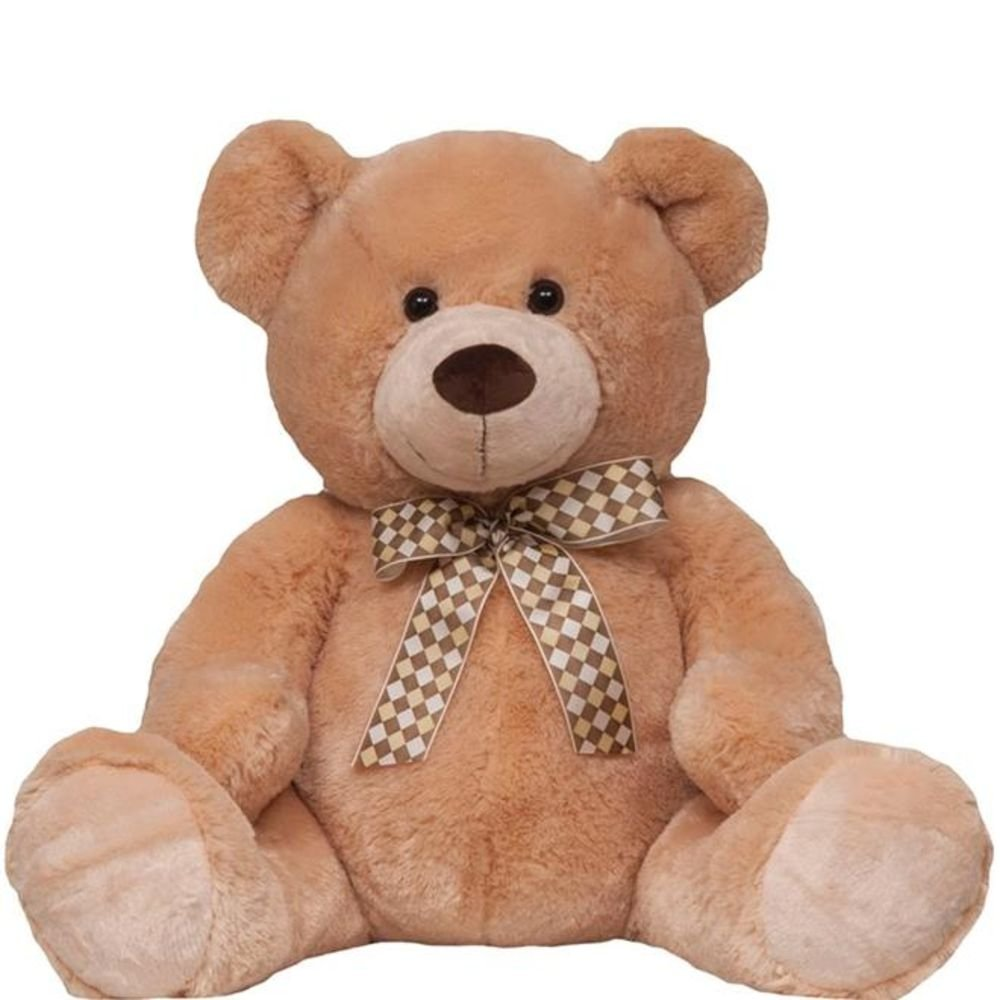
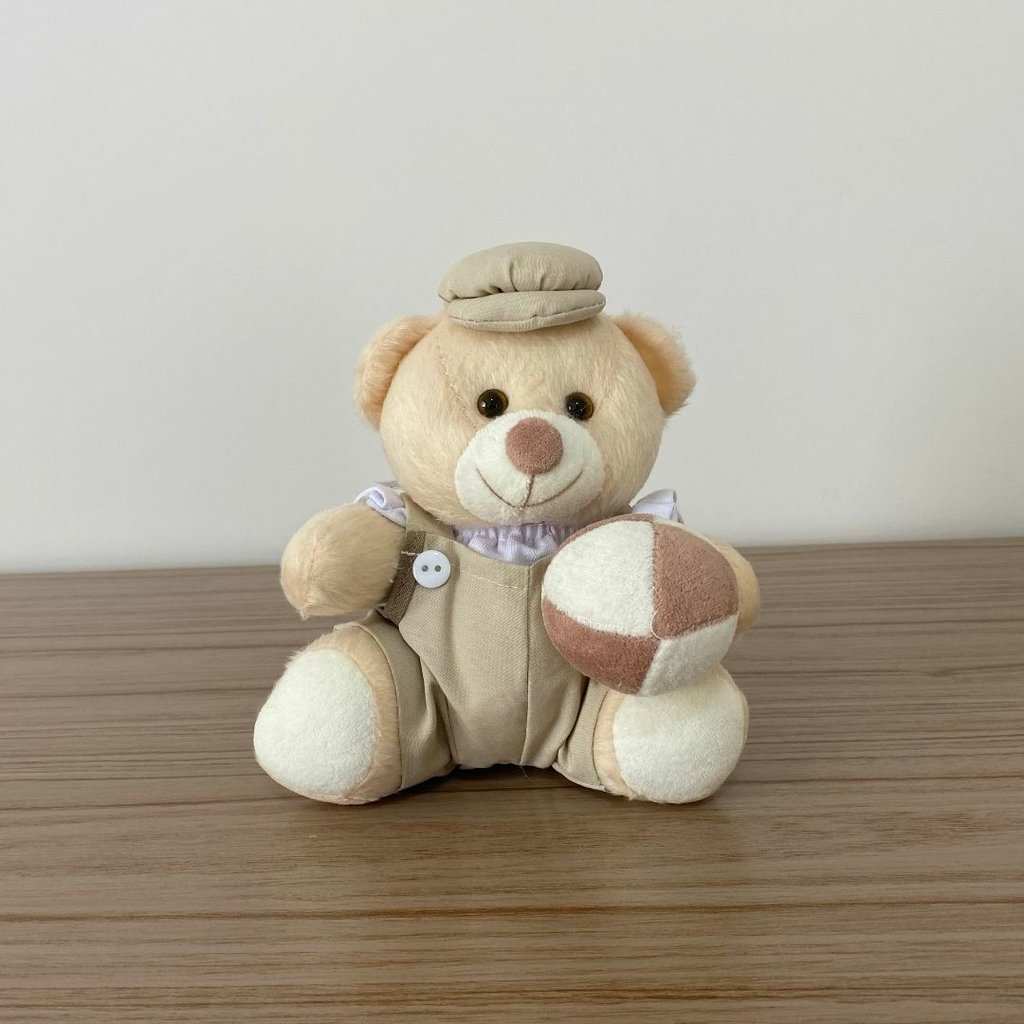
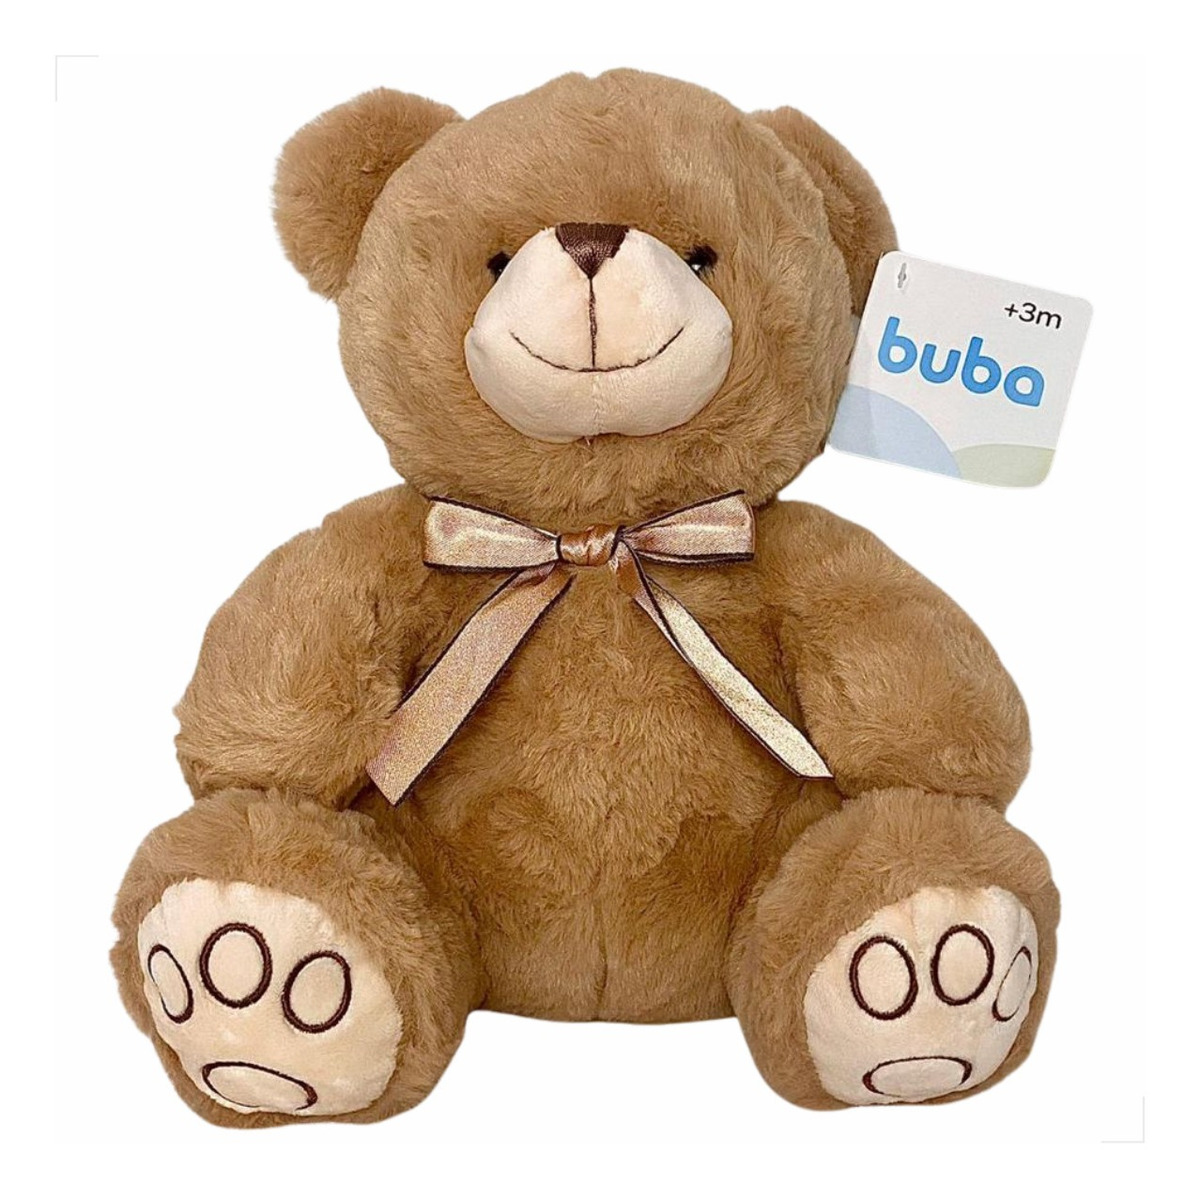
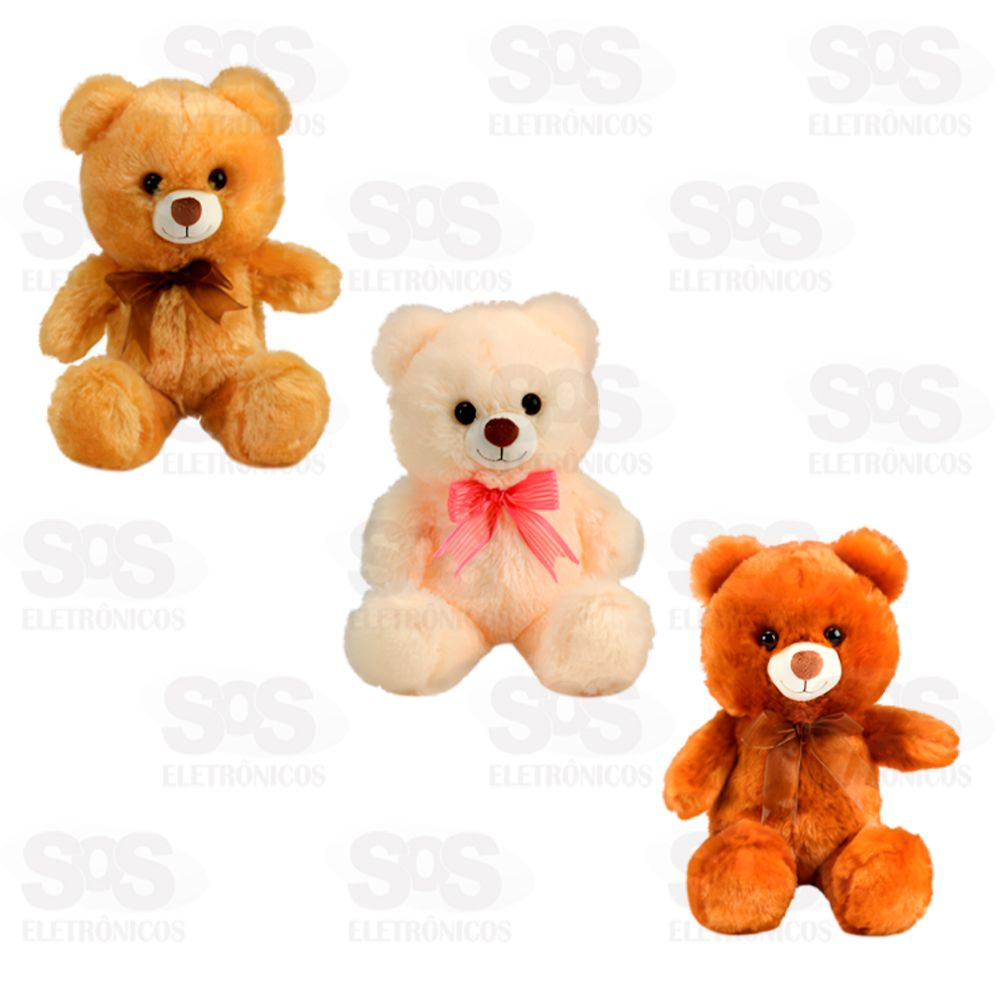
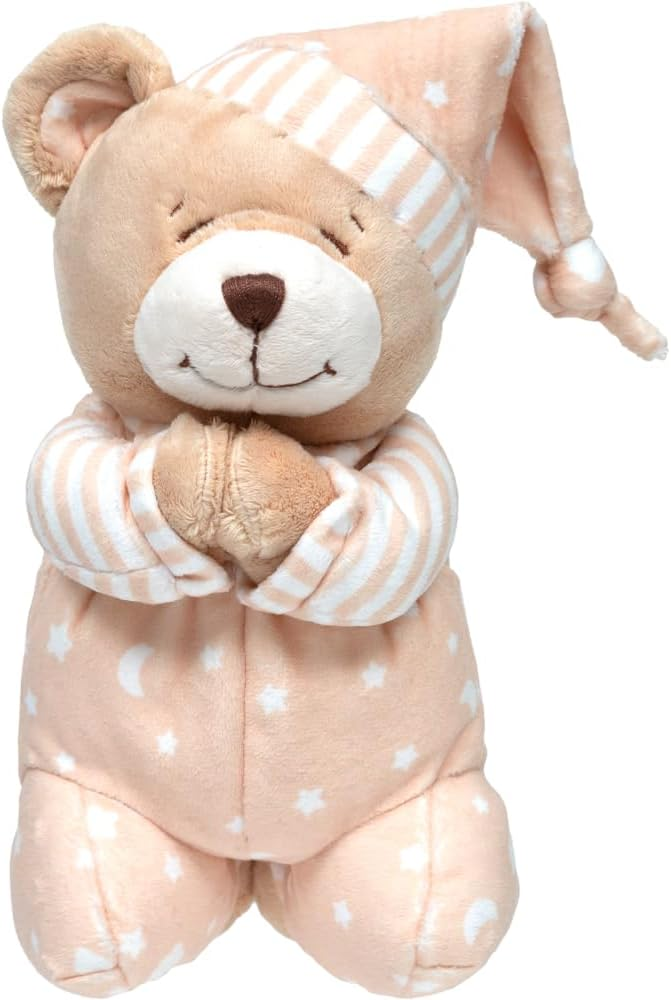


🔎 Buscando similares para 'cadeira'...



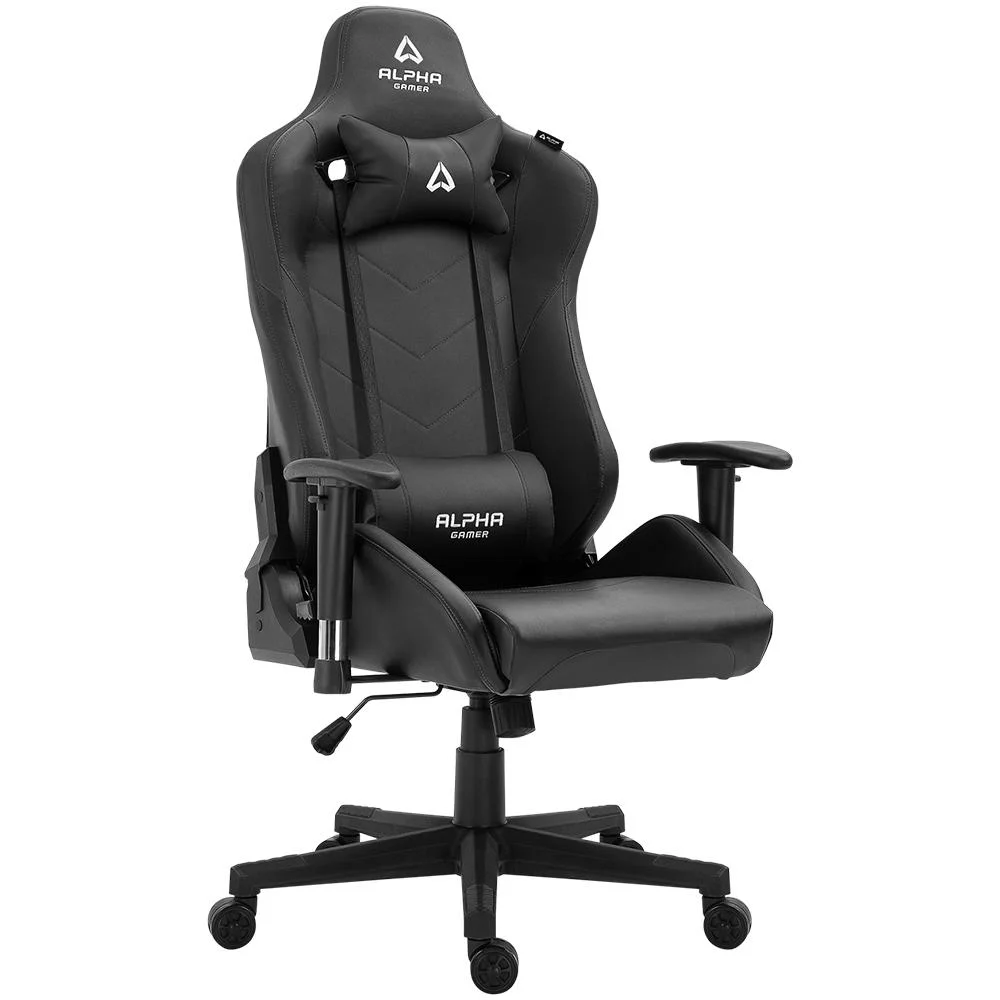
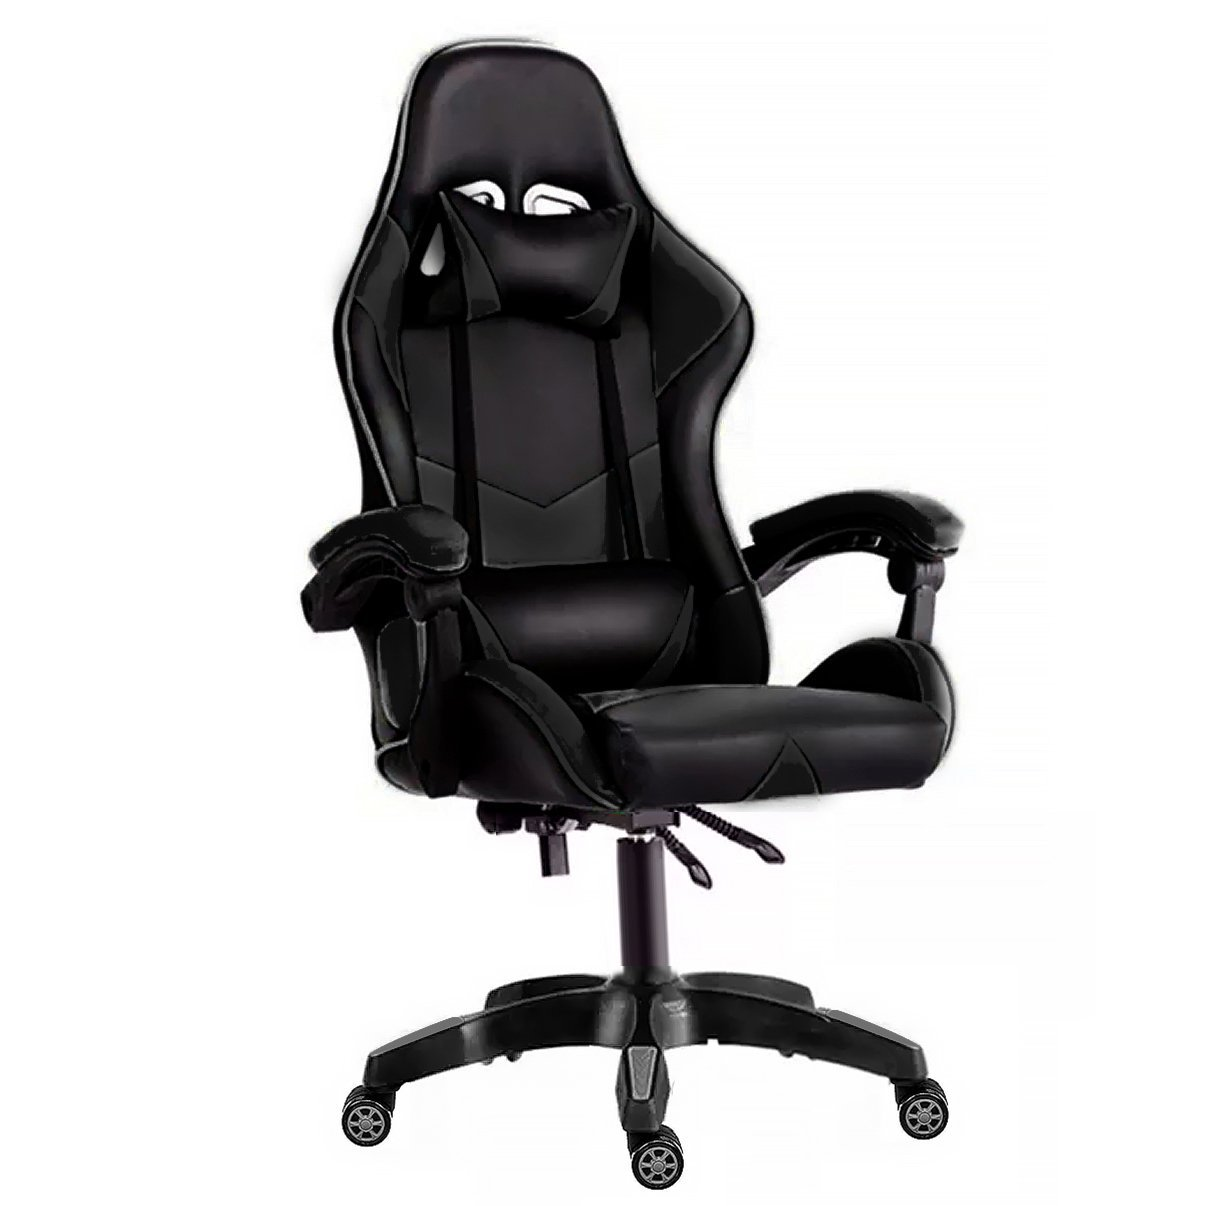
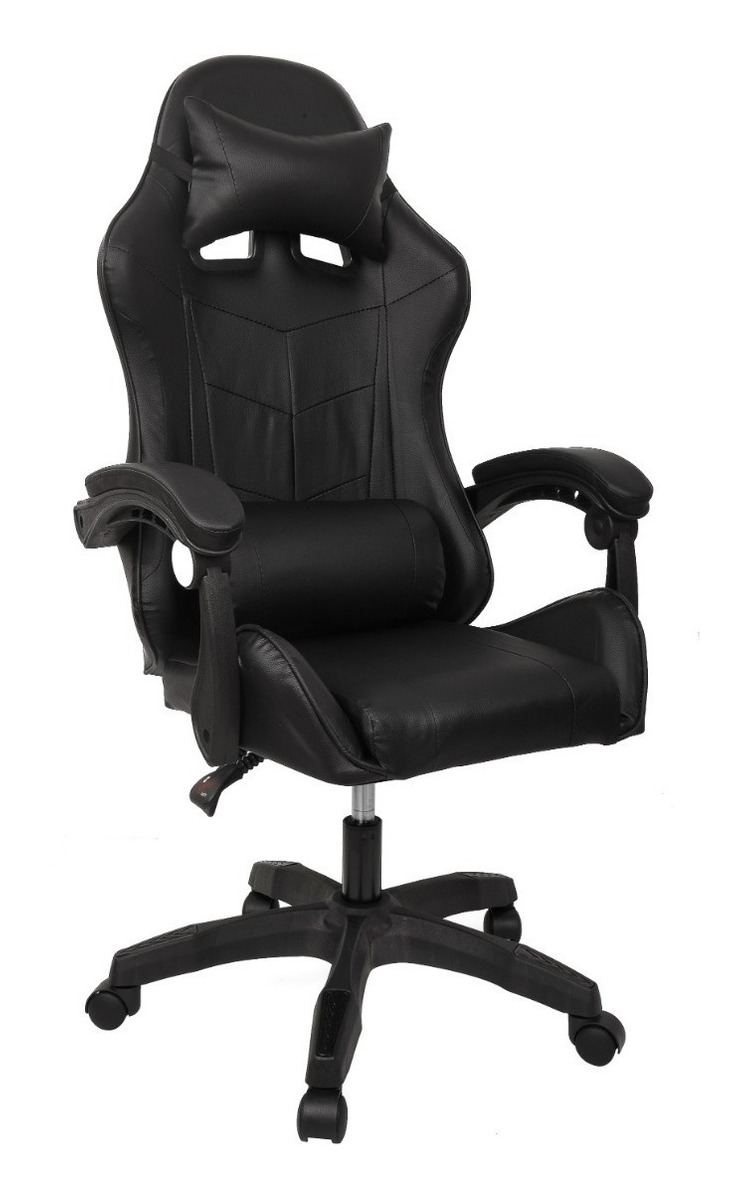
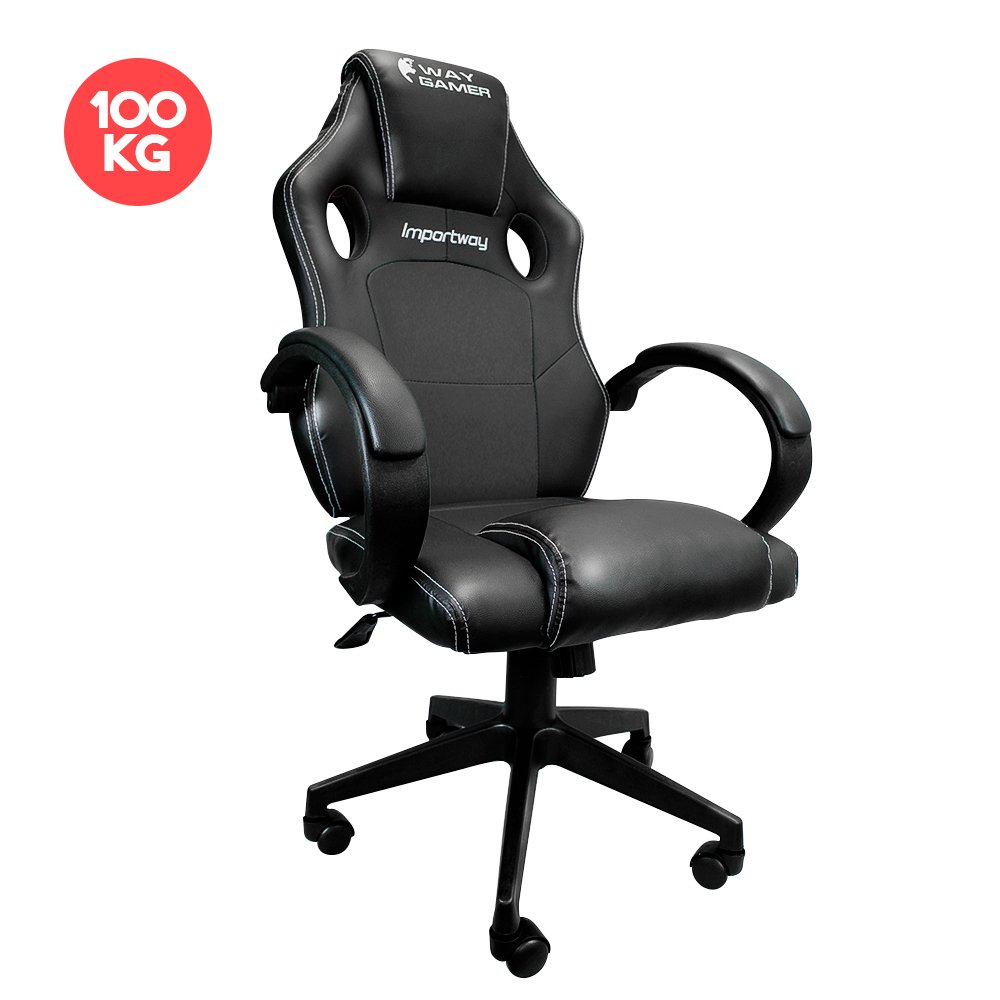
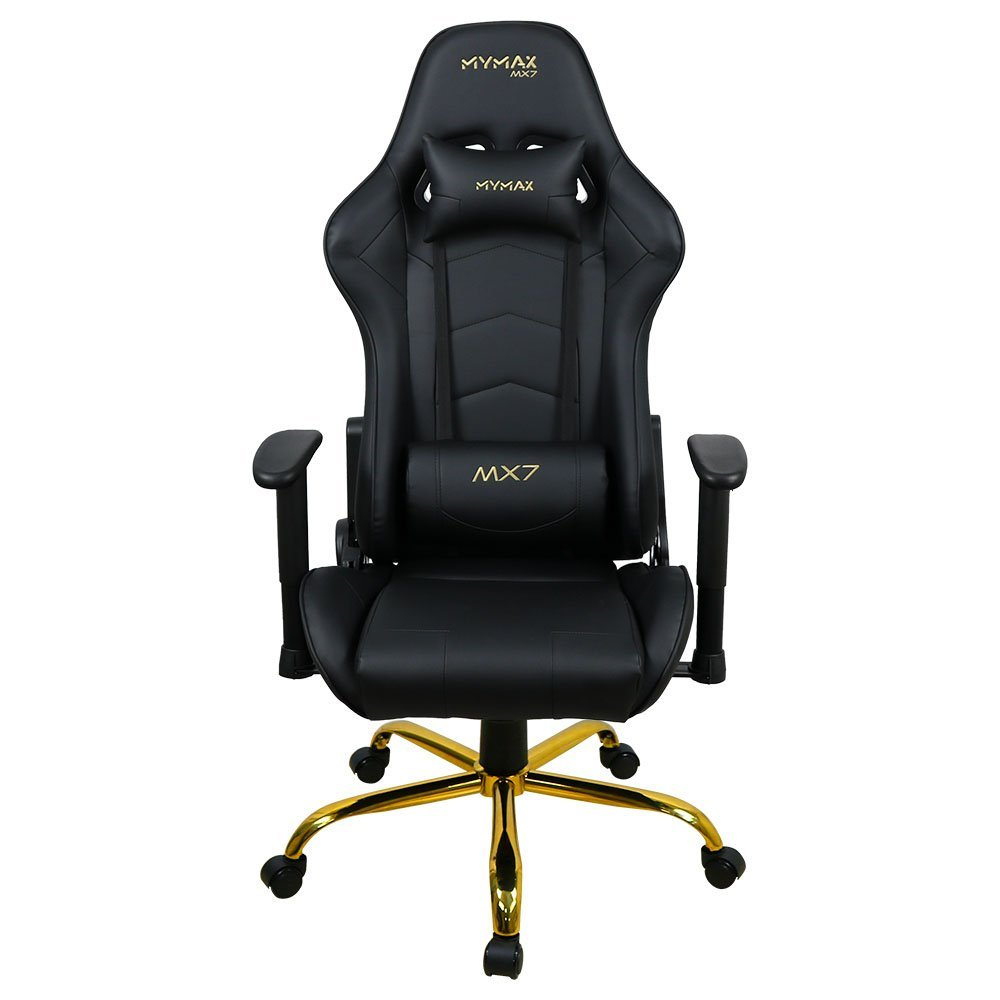


🔎 Buscando similares para 'bolsa'...



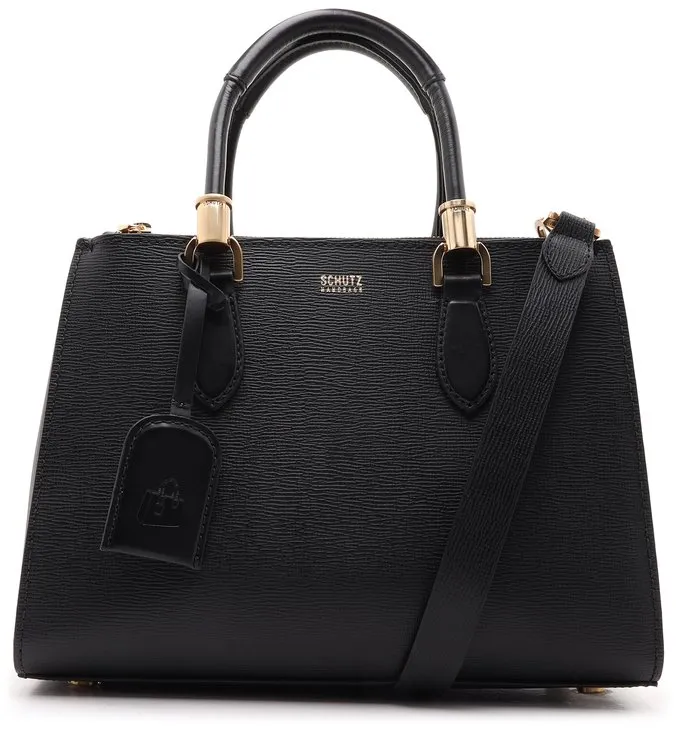
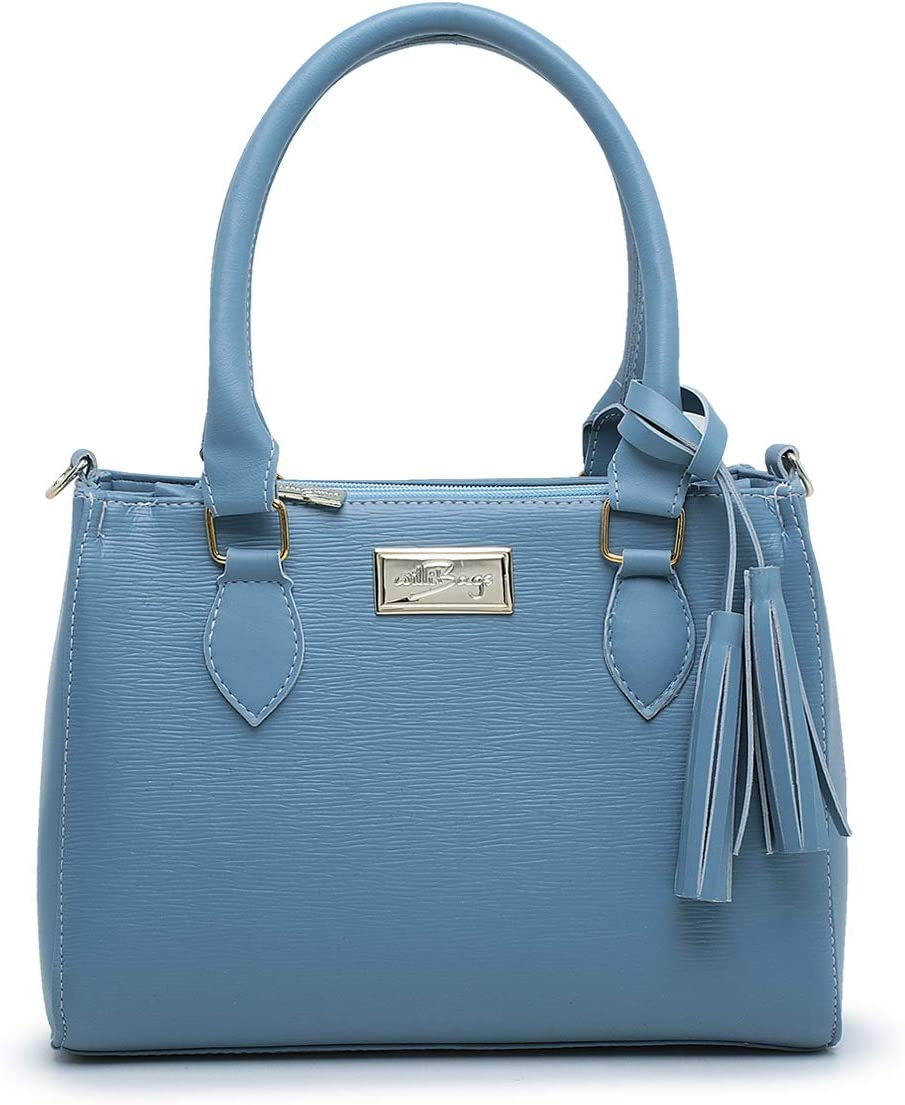
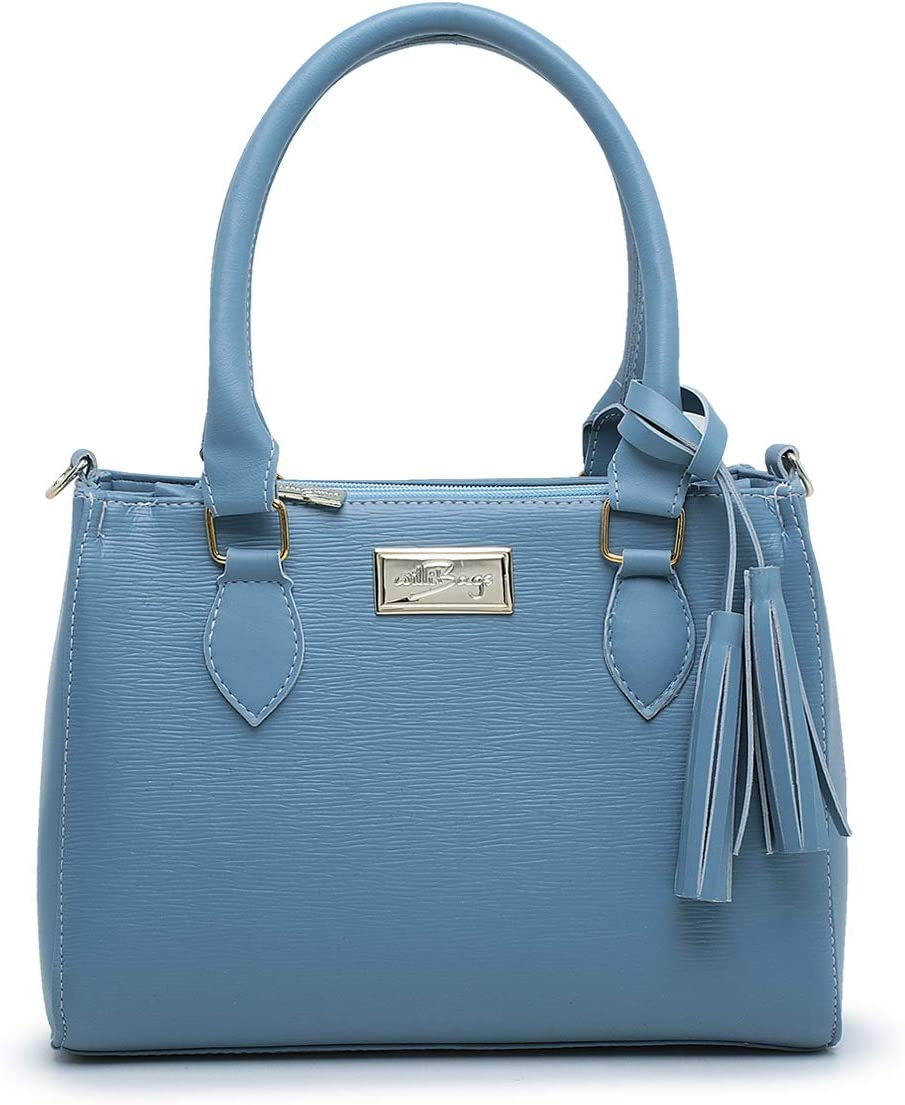
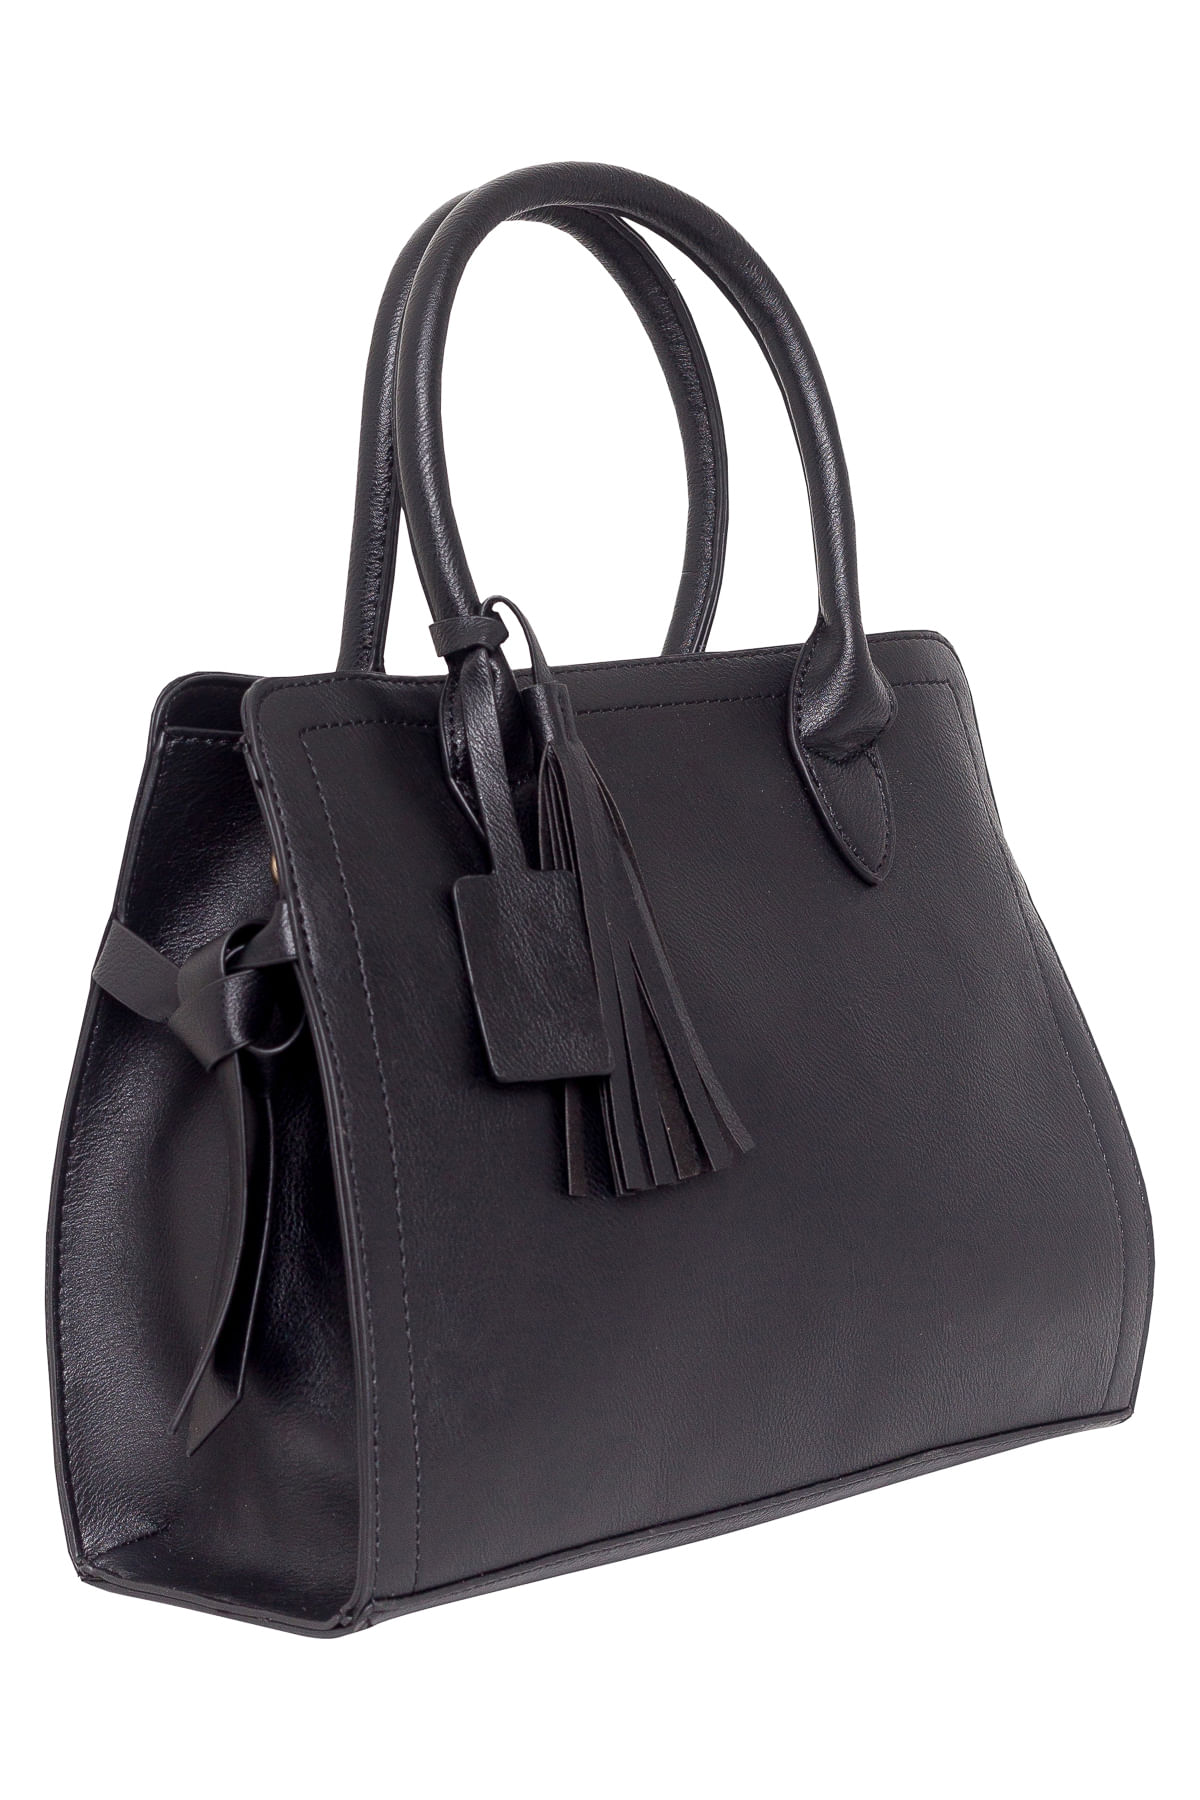
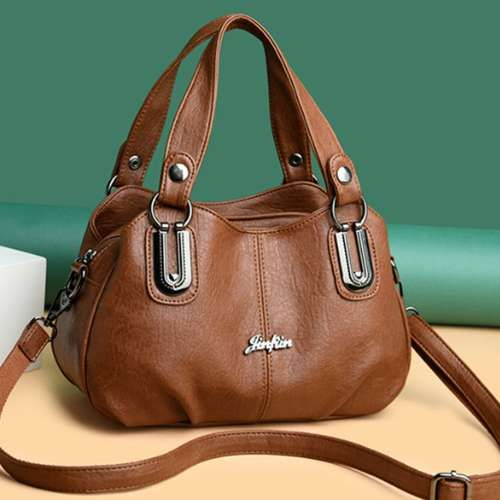


🔎 Buscando similares para 'chapeu'...



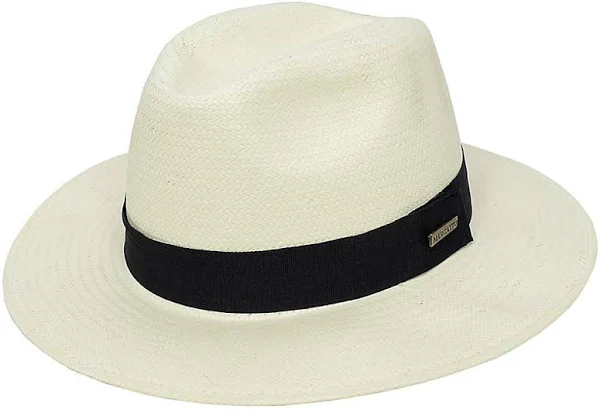
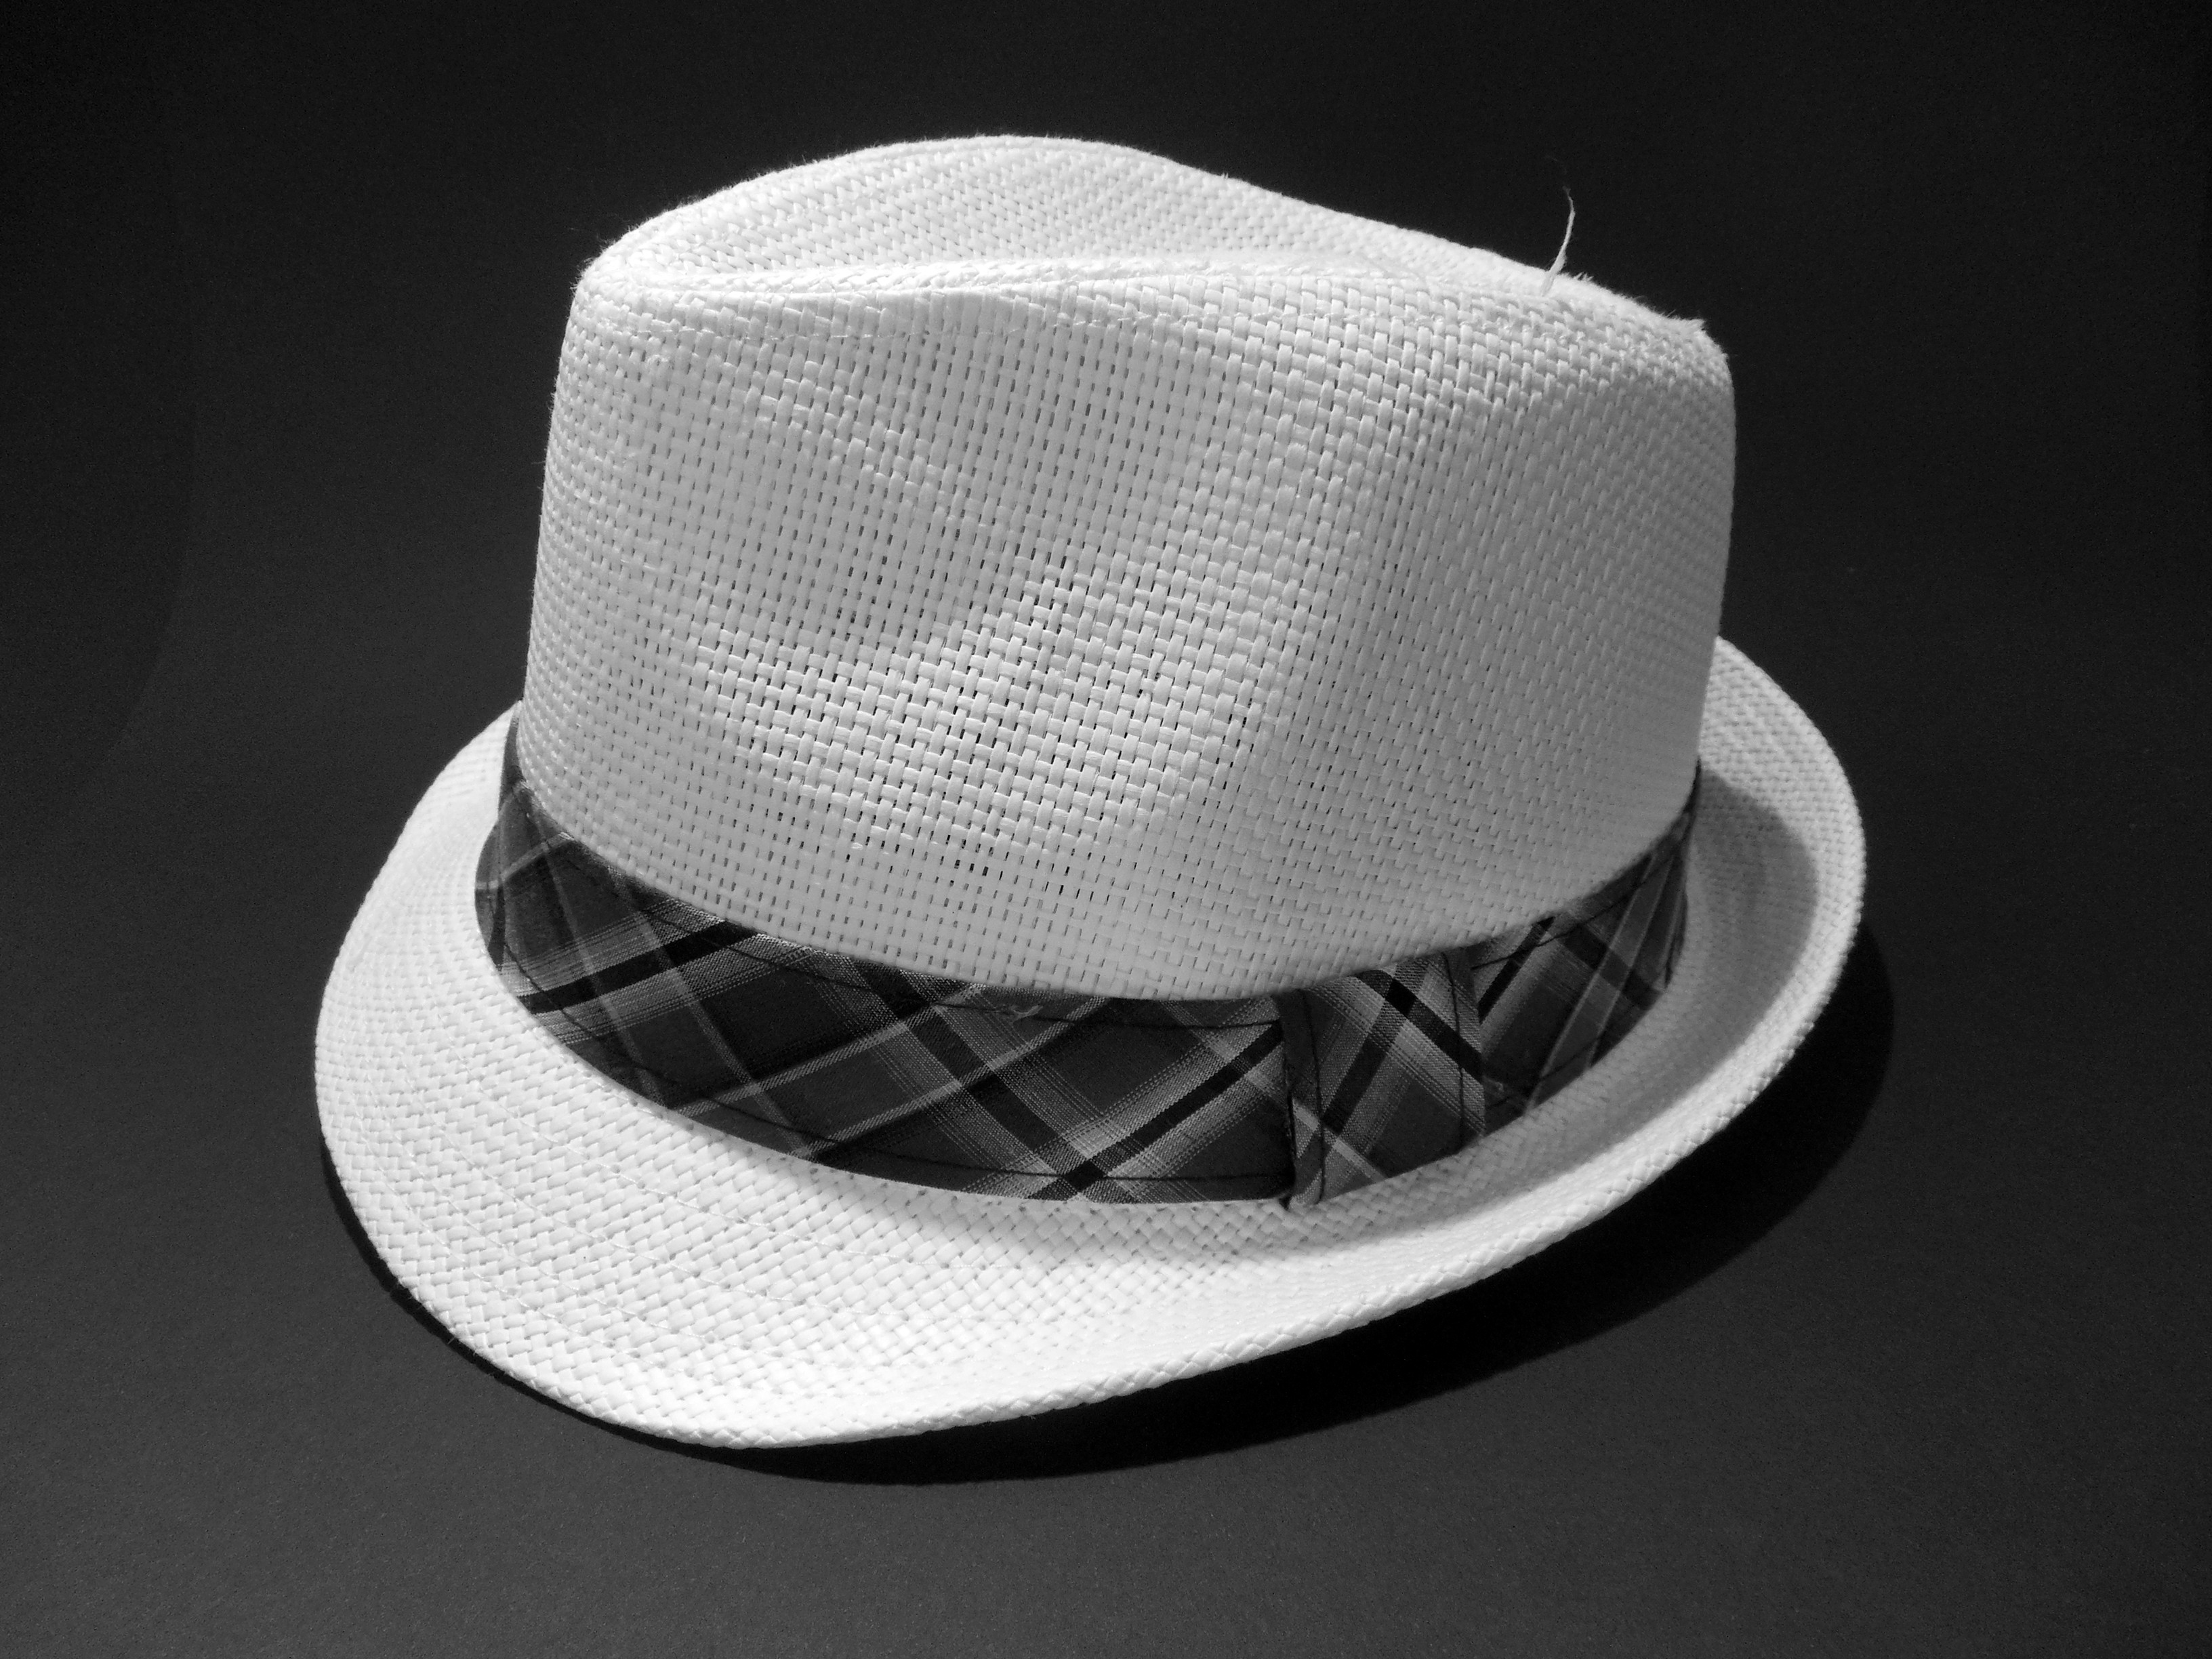
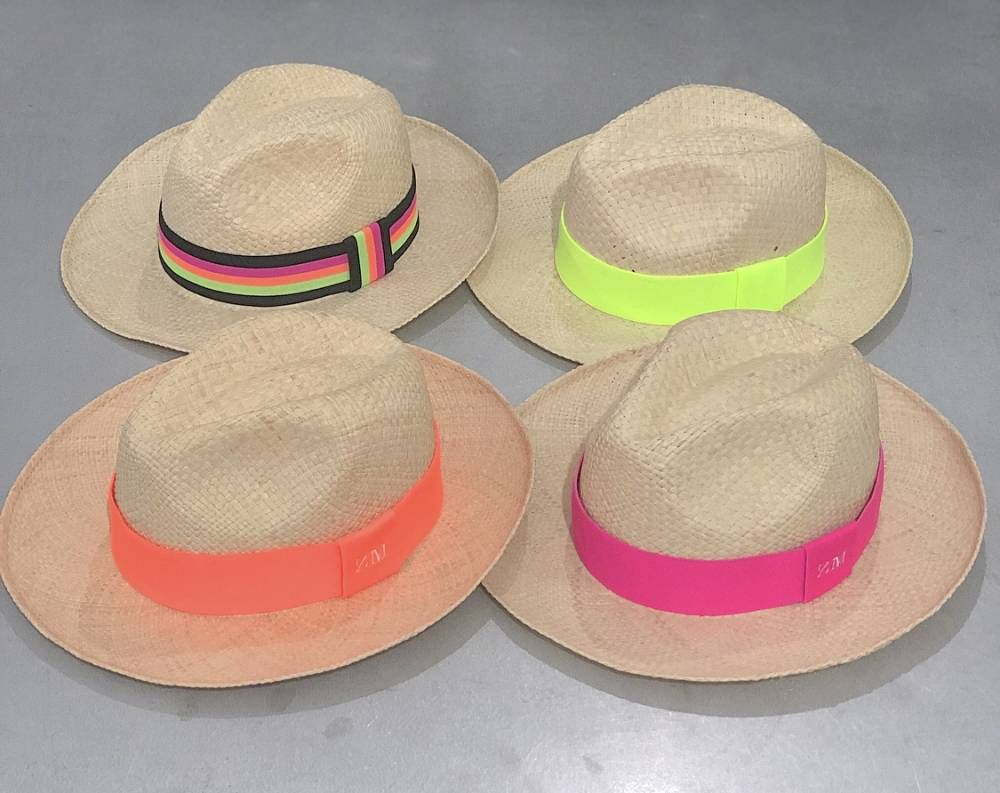
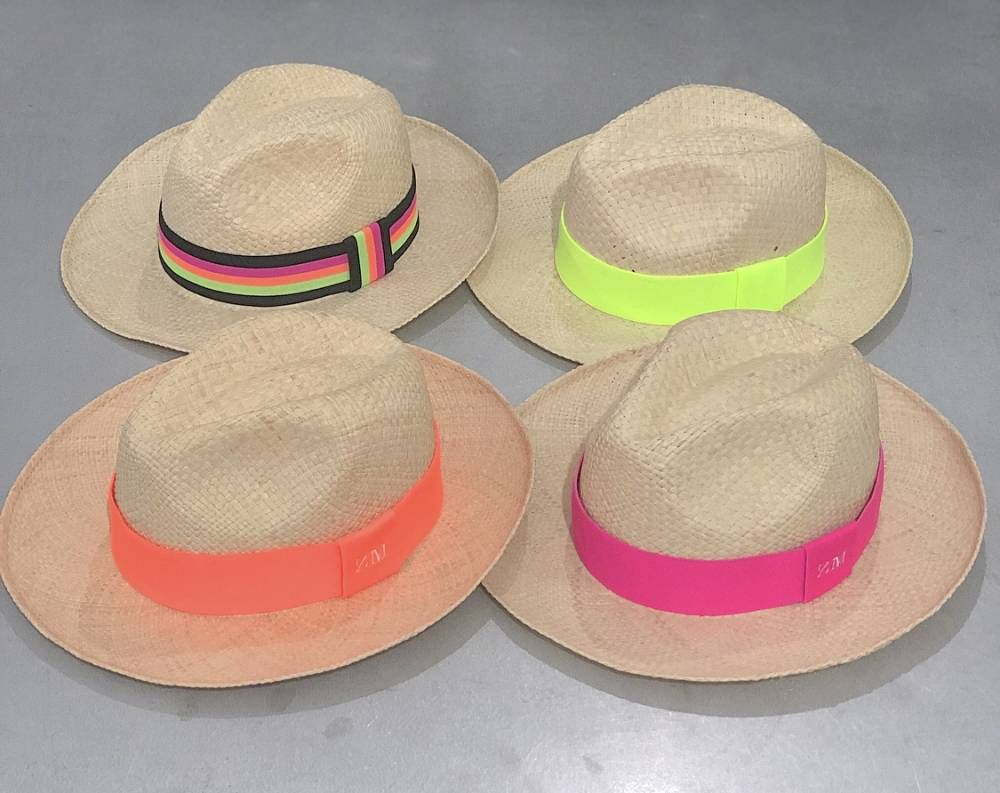
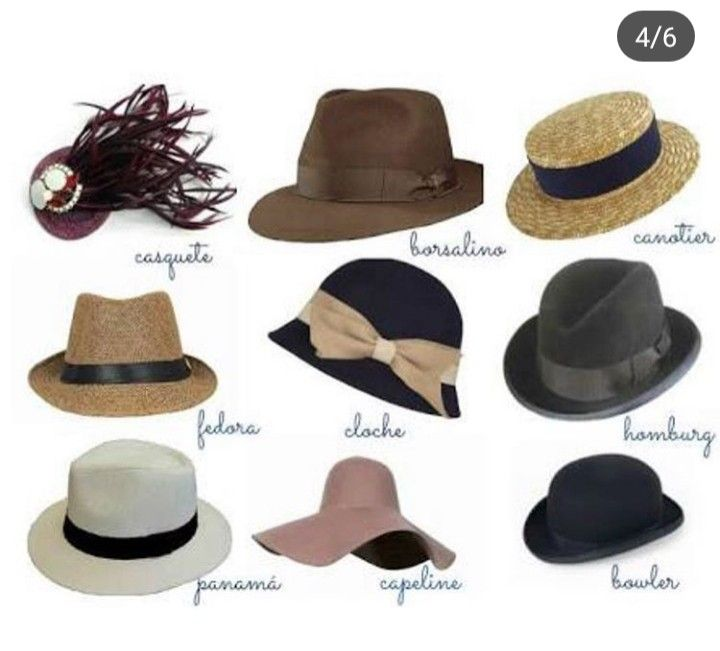

In [14]:
# ---------- 8) Consultar similaridade ----------
import base64

def mostrar_similares(short_cls, query_path, k=4):
    print(f"\n🔎 Buscando similares para '{short_cls}'...")

    query_feat = extrair_features(query_path).reshape(1, -1).astype('float32')
    distances, indices = index.search(query_feat, k)

    # Converter L2 entre vetores normalizados em cosine similarity
    cosine_sims = 1 - (distances**2)/2

    # Construir grid HTML
    html = "<div style='display:flex; flex-wrap: wrap; align-items: flex-start;'>"

    # Imagem de consulta
    with open(query_path, "rb") as f:
        img_bytes = f.read()
    encoded = base64.b64encode(img_bytes).decode()
    html += f"""
        <div style='margin:10px; text-align:center'>
            <b>Consulta ({short_cls})</b><br>
            <img src='data:image/jpeg;base64,{encoded}' style='height:150px; border:3px solid red'/>
        </div>
    """

    # Imagens similares ordenadas por cosine similarity decrescente
    sorted_idx = np.argsort(-cosine_sims[0])
    for rank, idx in enumerate(sorted_idx):
        sim_path = all_img_paths[indices[0][idx]]
        sim_val = cosine_sims[0][idx]
        with open(sim_path, "rb") as f:
            img_bytes = f.read()
        encoded = base64.b64encode(img_bytes).decode()
        html += f"""
            <div style='margin:10px; text-align:center'>
                <b>Similar {rank+1}</b><br>
                <img src='data:image/jpeg;base64,{encoded}' style='height:150px;'/><br>
                <span style='font-size:12px; color:gray'>cos_sim={sim_val:.4f}</span>
            </div>
        """

    html += "</div><hr>"
    display(HTML(html))

# Rodar para todas as classes
for short_cls, qpath in query_map.items():
    mostrar_similares(short_cls, qpath, k=top_k)